<a href="https://colab.research.google.com/github/andigu/crbm/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
import tensorflow_probability as tfp
import numpy as np 
from sklearn.neural_network import BernoulliRBM
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Real RBM

In [ ]:
class RBM(tf.keras.models.Model):
    def __init__(self, nv=2, nh=20, **kwargs):
        super(RBM, self).__init__(**kwargs)
        self.nv, self.nh = nv, nh
        self.W = tf.Variable(tf.random.normal((nv, nh)), trainable=True)
        self.bv = tf.Variable(tf.random.normal((nv, 1)), trainable=True) 
        self.bh = tf.Variable(tf.random.normal((nh, 1)), trainable=True)
        
    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random.uniform(p.shape)))
    
    def energy(self, v):
        b_term = tf.squeeze(tf.matmul(v, self.bv))
        linear_tranform = tf.matmul(v, self.W) + tf.squeeze(self.bh)
        h_term = tf.reduce_sum(tf.math.log(tf.exp(linear_tranform) + 1), axis=1) 
        return tf.reduce_mean(-h_term -b_term)
    
    def sample_h(self, v):
        ph_given_v = tf.sigmoid(tf.matmul(v, self.W) + tf.squeeze(self.bh))
        return self.bernoulli(ph_given_v)
    
    def sample_v(self, h):
        pv_given_h = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + tf.squeeze(self.bv))
        return self.bernoulli(pv_given_h)
    
    def gibbs_step(self, i, vk):
        hk = self.sample_h(vk)
        vk = self.sample_v(hk)
        return i+1, vk
    
    def gibbs_sample(self, n_samples, n_steps=3):
        init = tf.cast(tf.random.uniform(shape=(n_samples, self.nv), maxval=1) <= 0.5, tf.float32)
        _, x_samples = tf.while_loop(cond=lambda i, _: i <= n_steps, body = rbm.gibbs_step, 
                              loop_vars = [0, init], parallel_iterations=1,)
        return x_samples
    
    def call(self, x):
        x_samples = self.gibbs_sample(100*len(x))
        self.add_loss(self.energy(x) - self.energy(tf.stop_gradient(x_samples)))

In [ ]:
def to_freq(data):
    data = np.packbits(data.astype(np.int), axis=1, bitorder='little').flatten()
    vals, freq = np.unique(data, return_counts=True)
    return freq/freq.sum()

In [ ]:
from tqdm import trange
data_vals = []
weights = np.random.normal(size=4)
probs = np.abs(np.random.normal(size=4))
probs = probs/probs.sum()
for _ in trange(1000):
    tmp = np.random.choice(4, p=probs, size=5000)
    options = np.array([[0,0],[0,1],[1,0],[1,1]])
    X = options[tmp].astype(np.float32)
    data_vals.append(weights @ (to_freq(X)))

100%|██████████| 1000/1000 [00:00<00:00, 1522.73it/s]


In [ ]:
X.shape

(5000, 2)

In [ ]:
rbm = RBM(nh=20)
rbm_vals = []
rbm.compile(optimizer=tf.optimizers.SGD(0.1))
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)
]
rbm.fit(X, batch_size=10, verbose=2, epochs=200, callbacks=callbacks)
rbm.load_weights('model.h5')
to_freq(rbm.gibbs_sample(100000, n_steps=3).numpy()), to_freq(X)
for _ in trange(100):
    rbm_vals.append(weights @ (to_freq(rbm.gibbs_sample(100000).numpy())))

Epoch 1/200
500/500 - 1s - loss: 0.0129
Epoch 2/200
500/500 - 1s - loss: 0.0137
Epoch 3/200
500/500 - 1s - loss: 0.0232
Epoch 4/200
500/500 - 1s - loss: 0.0185
Epoch 5/200
500/500 - 1s - loss: 0.0193
Epoch 6/200
500/500 - 1s - loss: 0.0185
Epoch 7/200
500/500 - 1s - loss: 0.0088
Epoch 8/200
500/500 - 1s - loss: 0.0045
Epoch 9/200
500/500 - 1s - loss: 0.0046
Epoch 10/200
500/500 - 1s - loss: 0.0018
Epoch 11/200
500/500 - 1s - loss: 0.0022
Epoch 12/200
500/500 - 1s - loss: 0.0035
Epoch 13/200
500/500 - 1s - loss: 0.0018
Epoch 14/200
500/500 - 1s - loss: 0.0034
Epoch 15/200
500/500 - 1s - loss: 0.0014
Epoch 16/200
500/500 - 1s - loss: 0.0034
Epoch 17/200
500/500 - 1s - loss: 0.0027
Epoch 18/200
500/500 - 1s - loss: 5.7491e-04
Epoch 19/200
500/500 - 1s - loss: 0.0021
Epoch 20/200
500/500 - 1s - loss: 0.0014
Epoch 21/200
500/500 - 1s - loss: 0.0019
Epoch 22/200
500/500 - 1s - loss: 0.0027
Epoch 23/200
500/500 - 1s - loss: 0.0017
Epoch 24/200
500/500 - 1s - loss: 0.0014
Epoch 25/200
500/500 

100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


In [ ]:
np.round(to_freq(rbm.gibbs_sample(100000).numpy()),3), np.round(to_freq(X),3)

(array([0.326, 0.147, 0.162, 0.365]), array([0.325, 0.146, 0.164, 0.366]))

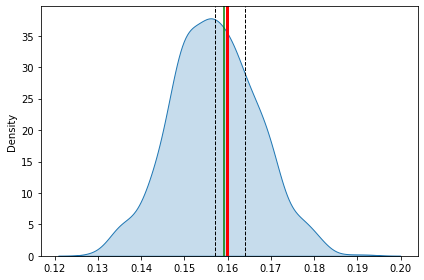

In [ ]:
sns.kdeplot(data_vals, fill=True)
plt.axvline(np.percentile(np.array(rbm_vals), 5), c='black', ls='--', lw=1)
plt.axvline(np.percentile(np.array(rbm_vals), 95), c='black', ls='--', lw=1)
plt.axvline(np.percentile(np.array(rbm_vals), 50), c='red', lw=3)
plt.axvline(weights@to_freq(X), c='green')
plt.tight_layout()

# Complex RBM

In [356]:
psi_z = np.random.normal(size=2) + np.random.normal(size=2) * 1j
psi_z = psi_z/np.linalg.norm(psi_z)
psi_z

array([0.0962174 +0.8060157j , 0.46011337-0.35968959j])

In [357]:
COBS = np.array([
    [
     [-1/np.sqrt(2), 1/np.sqrt(2)], # complex conjugate of 1st x vector in z basis
     [ 1/np.sqrt(2), 1/np.sqrt(2)]
    ],
    [
     [1j/np.sqrt(2), 1/np.sqrt(2)], # complex conjugate of 1st y vector
     [-1j/np.sqrt(2), 1/np.sqrt(2)]
    ],
    [
     [1, 0],
     [0, 1]
    ]
])
def draw_from_psi(psi_z, N=10000, basis=2):
    sigma = np.take(COBS, basis, axis=0)
    psi_proj = (sigma @ psi_z[:,np.newaxis]).flatten()
    probs = psi_proj * np.conj(psi_proj)
    res = np.random.multinomial(n=1, pvals=np.real(probs), size=N)
    return np.argwhere(res)[:,1]

Z_samples = draw_from_psi(psi_z, N=5000, basis=2)
X_samples = draw_from_psi(psi_z, N=5000, basis=0)

In [358]:
class CRBM(tf.keras.models.Model):
    def __init__(self, nv=1, nh=5):
        super(CRBM, self).__init__()
        self.nv, self.nh = nv, nh
        self.bv = tf.Variable(initial_value=CRBM.random_normal((nv,1)), dtype=tf.dtypes.complex64)
        self.bh = tf.Variable(initial_value=CRBM.random_normal((nh,1)), dtype=tf.dtypes.complex64)
        self.W = tf.Variable(initial_value=CRBM.random_normal((nv, nh)), dtype=tf.dtypes.complex64)
        v_vecs = np.array([list("{0:b}".format(x).zfill(nv)) for x in np.arange(2**nv)]).astype(np.int)
        self.v_vecs = tf.cast(tf.convert_to_tensor(v_vecs), tf.dtypes.complex64)
        self.COBS = tf.cast(tf.convert_to_tensor(COBS), tf.dtypes.complex64)
    
    @staticmethod
    def random_normal(shape):
        return np.random.normal(size=shape) + 1j*np.random.normal(size=shape)
    
    def psi(self, v):
        """
        Accepts only length N binary strings
        """
        if tf.rank(v) == 1:
            v = tf.expand_dims(v, axis=-1)
        elif tf.rank(v) == 2:
            v = tf.transpose(v)
        ret = tf.linalg.adjoint(self.bv) @ v + tf.reduce_sum(tf.math.log(tf.math.conj(tf.exp(self.bh + tf.linalg.adjoint(self.W) @ v)) + 1), axis=0)
        return tf.transpose(tf.exp(ret))

    def prob(self, spins, basis):
        basis = tf.cast(basis, tf.int64)
        indexing = tf.concat((basis, spins), axis=-1)
        sigma = tf.math.conj(tf.cast(tf.gather_nd(self.COBS, indexing), tf.dtypes.complex64)) # sigma = <v_i | measured state vector>
        psi_vec = self.psi(self.v_vecs)
        psi_proj = sigma @ psi_vec
        return tf.cast(psi_proj*tf.math.conj(psi_proj)/tf.linalg.norm(psi_vec)**2, tf.float32)

    def call(self, measurement):
        spins = measurement[0]
        basis = measurement[1]
        probs = self.prob(spins, basis=basis)
        self.add_loss(-tf.math.reduce_mean(tf.math.log(probs)))

In [359]:
bs = 100
measurements = np.expand_dims(np.concatenate((X_samples, Z_samples), axis=0), axis=-1)
bases = np.expand_dims(np.concatenate((np.zeros(len(X_samples)), 2*np.ones(len(Z_samples))), axis=0), axis=-1)

In [412]:
!rm -rf imgs
!mkdir imgs
import imageio
from datetime import datetime
import os
from qiskit.visualization import plot_bloch_vector
class Visualize(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch <= 20:
            tmp = psi_z/psi_z[0]
            tmp = tmp/np.linalg.norm(tmp)
            theta = np.arccos(tmp[0].real)*2
            phi = np.angle(tmp[1])

            fig = plot_bloch_vector([1,theta,phi], coord_type='spherical', title=f'Epoch {epoch}')
            psi = self.model.psi(self.model.v_vecs)
            psi = (psi/np.linalg.norm(psi)).numpy().flatten()
            tmp = psi/psi[0]
            tmp = tmp/np.linalg.norm(tmp)
            theta = np.arccos(tmp[0].real)*2
            phi = np.angle(tmp[1])
            plot_bloch_vector([1,theta,phi], coord_type='spherical', ax=fig.gca(), title=f'Epoch {epoch}')
            fig.savefig(f"imgs/epoch-{str(epoch).zfill(3)}.png", bbox_inches='tight')
    
    def on_train_end(self, logs):
        images = []
        for filename in sorted(os.listdir("imgs/"), key=lambda x: int(x.split('.')[0][-3:])):
            images.append(imageio.imread(f"imgs/{filename}"))
        for _ in range(10):
            images.append(imageio.imread(f"imgs/{filename}"))
        date = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
        imageio.mimsave(f'{date}.gif', images)
        self.model.load_weights("model.h5")

crbm = CRBM(nv=1, nh=5)
crbm.compile(optimizer=tf.optimizers.Adam(0.1))
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30),
    tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='loss', verbose=True, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=True, min_lr=1e-5),
    tf.keras.callbacks.CSVLogger("training.csv"),
    Visualize()
]
hist = crbm.fit(x=(measurements, bases), verbose=2, epochs=200, callbacks=callbacks, batch_size=200, shuffle=True)

Epoch 1/200

Epoch 00001: loss improved from inf to 0.71612, saving model to model.h5
50/50 - 0s - loss: 0.7161
Epoch 2/200

Epoch 00002: loss improved from 0.71612 to 0.61793, saving model to model.h5
50/50 - 0s - loss: 0.6179
Epoch 3/200

Epoch 00003: loss improved from 0.61793 to 0.61299, saving model to model.h5
50/50 - 0s - loss: 0.6130
Epoch 4/200

Epoch 00004: loss improved from 0.61299 to 0.61030, saving model to model.h5
50/50 - 0s - loss: 0.6103
Epoch 5/200

Epoch 00005: loss improved from 0.61030 to 0.60696, saving model to model.h5
50/50 - 0s - loss: 0.6070
Epoch 6/200

Epoch 00006: loss did not improve from 0.60696
50/50 - 0s - loss: 0.6074
Epoch 7/200

Epoch 00007: loss did not improve from 0.60696
50/50 - 0s - loss: 0.6082
Epoch 8/200

Epoch 00008: loss did not improve from 0.60696
50/50 - 0s - loss: 0.6102
Epoch 9/200

Epoch 00009: loss did not improve from 0.60696
50/50 - 0s - loss: 0.6196
Epoch 10/200

Epoch 00010: loss did not improve from 0.60696

Epoch 00010: Reduc

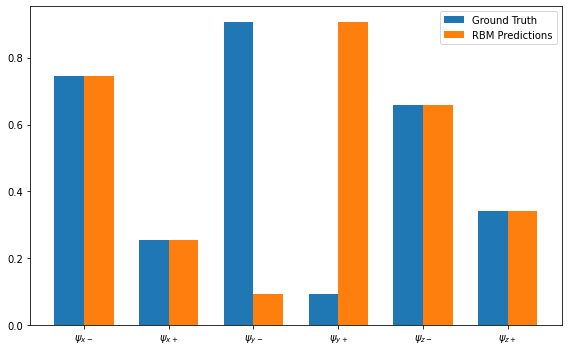

In [437]:
plt.figure(figsize=(8,5))
grnd_truth = [np.abs(psi_z[0] - psi_z[1])**2/2, np.abs(psi_z[0] + psi_z[1])**2/2, np.abs(psi_z[0] + 1j* psi_z[1])**2/2, np.abs(psi_z[0] - 1j* psi_z[1])**2/2, np.abs(psi_z[0])**2, np.abs(psi_z[1])**2]
psi = crbm.psi(crbm.v_vecs)
psi = (psi/np.linalg.norm(psi)).numpy().flatten()
rbm_pred = [np.abs(psi[0] - psi[1])**2/2, np.abs(psi[0] + psi[1])**2/2, np.abs(psi[0] + 1j* psi[1])**2/2, np.abs(psi[0] - 1j* psi[1])**2/2, np.abs(psi[0])**2, np.abs(psi[1])**2]
labels = [r'$\psi_{x-}$','$\psi_{x+}$','$\psi_{y-}$','$\psi_{y+}$','$\psi_{z-}$','$\psi_{z+}$',]
x = np.arange(len(labels))
width=0.35
plt.bar(x-width/2, grnd_truth, width=width, label='Ground Truth')
plt.bar(x+width/2, rbm_pred, width=width, label='RBM Predictions')
plt.legend()
plt.xticks(ticks=x, labels=labels);
plt.tight_layout()

In [443]:
sv = qiskit.quantum_info.Statevector(psi)
sv.expectation_value(qiskit.quantum_info.Pauli.from_label("Z"))

(0.31409029204352784+0j)

In [441]:
rbm_pred

[0.7435589486295342,
 0.256441035638888,
 0.0925495574242188,
 0.9074504418976822,
 0.6570451789716714,
 0.34295488695130416]